이번 강의에서는 12장을 다룹니다. Eligibility Trace 역시 다른 강화학습 주제들처럼 개념을 이해하는 것이 중요합니다. 

코드는 지난 시간에 했던 Example 10.1 Mountain Car Task 를 다시 풀 거예요. 코드는 매우 간단하고, p.293의 Semi-gradient TD($\lambda$) for estimating $\hat{v} \approx v_\pi$ 알고리즘이니 교과서를 참고하면 돼요.

문제 구현 방법은 10장에서 구현했던 Mountain Car Task와 동일합니다.  

# 1. Example 10.1 Mountain Car Task 

## 1.1. Problem Definition

In [7]:
import numpy as np

class MountainCarEnv:
    def __init__(self, seed: int | None = None):
        self.x_min, self.x_max = -1.2, 0.5
        self.v_min, self.v_max = -0.07, 0.07
        self.goal_x = 0.5
        self.actions = np.array([-1, 0, +1], dtype=int)  # a ∈ {-1,0,+1}
        self.r_step = -1.0
        self._rng = np.random.RandomState(seed)
        self.state = None  # (x, v)

    def reset(self):
        x0 = self._rng.uniform(-0.6, -0.4)
        v0 = 0.0
        self.state = np.array([x0, v0], dtype=float)
        return self.state.copy()

    def step(self, a_idx: int):
        assert 0 <= a_idx < len(self.actions), "Invalid action index"
        a = float(self.actions[a_idx])

        x, v = self.state
        v_next = v + 0.001 * a - 0.0025 * np.cos(3.0 * x)
        v_next = np.clip(v_next, self.v_min, self.v_max)
        x_next = x + v_next

        if x_next < self.x_min:
            x_next = self.x_min
            v_next = 0.0

        done = x_next >= self.goal_x
        reward = 0.0 if done else self.r_step

        self.state = np.array([x_next, v_next], dtype=float)
        return self.state.copy(), reward, done, {}

    @property
    def n_actions(self) -> int:
        return len(self.actions)

    def sample_action(self) -> int:
        return int(self._rng.randint(self.n_actions))

# 나중에 어차피 쓸 epsilon greedy 함수입니다.
def epsilon_greedy(q_values: np.ndarray, epsilon: float, rng: np.random.RandomState) -> int:
    """
    q_values: shape (n_actions,)
    """
    if rng.rand() < epsilon:
        return int(rng.randint(q_values.shape[0]))
    max_as = np.flatnonzero(q_values == q_values.max())
    return int(rng.choice(max_as))

## Semi-gradient TD($\lambda$) for estimating $\hat{v} \approx v_\pi$ 

교수의 옛날 코드이니 학생들이 직접 수정해 보세요. 
  1. 코드를 이해한다.
  2. 직접 수정해야 할 내용을 찾아 본다. 
  3. 생성형AI의 도움을 받아 제안을 확인한다.
  

TD(lambda): 100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]


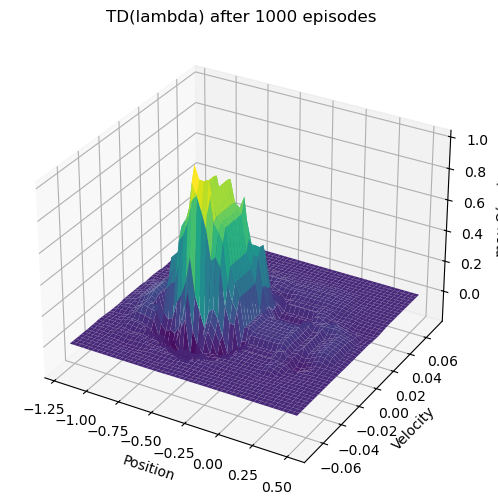

In [9]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class IHT:
    def __init__(self, size):
        self.size = size
        self.overfull_count = 0
        self.dictionary = {}

    def getindex(self, obj, readonly=False):
        if obj in self.dictionary:
            return self.dictionary[obj]
        elif readonly:
            return None
        if len(self.dictionary) >= self.size:
            return hash(obj) % self.size
        idx = len(self.dictionary)
        self.dictionary[obj] = idx
        return idx


def tiles(iht, num_tilings, floats, ints=None):
    if ints is None:
        ints = []
    coords = []
    qfloats = [f * num_tilings for f in floats]
    for tiling in range(num_tilings):
        c = [tiling]
        for q in qfloats:
            c.append(int((q + tiling) / num_tilings))
        c.extend(ints)
        coords.append(tuple(c))
    return [iht.getindex(coord) for coord in coords]


class TileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.x_min, self.x_max = -1.2, 0.5
        self.v_min, self.v_max = -0.07, 0.07

    def get_features(self, state):
        x, v = state
        xs = self.num_tiles / (self.x_max - self.x_min)
        vs = self.num_tiles / (self.v_max - self.v_min)
        return tiles(self.iht, self.num_tilings, [x * xs, v * vs])


class LinearQ_Tile:
    def __init__(self, n_actions, iht_size=4096):
        self.w = np.zeros((n_actions, iht_size))
        self.n_actions = n_actions

    def q_values(self, s, tc):
        idx = tc.get_features(s)
        return np.sum(self.w[:, idx], axis=1)

    def q_value(self, s, a, tc):
        idx = tc.get_features(s)
        return np.sum(self.w[a, idx])

    def grad(self, s, a, tc):
        idx = tc.get_features(s)
        g = np.zeros_like(self.w)
        g[a, idx] = 1.0
        return g

    def apply_update(self, update):
        self.w += update


def semi_grad_td_lambda(env, tc, lam=0.9, episodes=500, alpha=0.05, gamma=1.0, epsilon=0.1):
    Q = LinearQ_Tile(env.n_actions)
    rng = env._rng
    rewards = []

    for ep in tqdm(range(1, episodes + 1), desc="TD(lambda)"):
        s = env.reset()
        q_s = Q.q_values(s, tc)
        a = epsilon_greedy(q_s, epsilon, rng)
        z = np.zeros_like(Q.w)
        total_r = 0.0

        for _ in range(5000):
            s_next, r, done, _ = env.step(a)
            total_r += r

            if done:
                delta = r - Q.q_value(s, a, tc)
                z = gamma * lam * z + Q.grad(s, a, tc)
                Q.apply_update(alpha * delta * z)
                break

            q_next = Q.q_values(s_next, tc)
            a_next = epsilon_greedy(q_next, epsilon, rng)
            delta = r + gamma * Q.q_value(s_next, a_next, tc) - Q.q_value(s, a, tc)
            z = gamma * lam * z + Q.grad(s, a, tc)
            Q.apply_update(alpha * delta * z)
            s = s_next
            a = a_next

        rewards.append(total_r)

    return Q, rewards


def plot_value_surface(Q, tc, episodes_for_title=0, resolution=50):
    xs = np.linspace(-1.2, 0.5, resolution)
    vs = np.linspace(-0.07, 0.07, resolution)
    Z = np.zeros((resolution, resolution))

    for i, x in enumerate(xs):
        for j, v in enumerate(vs):
            q = Q.q_values((x, v), tc)
            Z[j, i] = -np.max(q)

    X, Y = np.meshgrid(xs, vs)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("-max Q(s,a)")
    ax.set_title(f"TD(lambda) after {episodes_for_title} episodes")
    plt.show()


tc = TileCoder(iht_size=4096)
env = MountainCarEnv(seed=1)
Q_lambda, rewards_lambda = semi_grad_td_lambda(env, tc, lam=0.9, episodes=1000, alpha=0.05, gamma=1.0, epsilon=0.1)
plot_value_surface(Q_lambda, tc, 1000)

# 2. Windy Gridwalk
## 2.1. Problem Definition

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


GRID_HEIGHT = 7
GRID_WIDTH = 10

WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

START_STATE = (3, 0)
GOAL_STATE = (3, 7)

ACTIONS_4 = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
ACTIONS_8 = ACTIONS_4 + [(-1, -1), (-1, 1), (1, -1), (1, 1)]
ACTIONS_9 = ACTIONS_8 + [(0, 0)]

ALPHA = 0.1
EPSILON = 0.1
GAMMA = 1.0

REWARD_PER_STEP = -1
REWARD_GOAL = 0

def env_step_stochastic_wind(state, action_idx, current_actions):
    y, x = state
    dy, dx = current_actions[action_idx]

    next_y_after_action = y + dy
    next_x_after_action = x + dx

    final_next_y = next_y_after_action
    final_next_x = next_x_after_action

    if 0 <= final_next_x < GRID_WIDTH:
        mean_wind_effect = WIND[final_next_x]
        
        rand_val = np.random.rand()
        if rand_val < 1/3:
            stochastic_wind_effect = mean_wind_effect - 1
        elif rand_val < 2/3:
            stochastic_wind_effect = mean_wind_effect
        else:
            stochastic_wind_effect = mean_wind_effect + 1
        
        final_next_y -= stochastic_wind_effect

    final_next_y = max(0, min(final_next_y, GRID_HEIGHT - 1))
    final_next_x = max(0, min(final_next_x, GRID_WIDTH - 1))

    next_state = (final_next_y, final_next_x)

    reward = REWARD_PER_STEP
    if next_state == GOAL_STATE:
        reward = REWARD_GOAL       

    return next_state, reward

def plot_results(results, labels, title, x_limit=8000):
    plt.figure(figsize=(12, 6))
    
    for i, res in enumerate(results):
        cumulative_steps = np.cumsum(res)
        episodes_within_limit = np.sum(cumulative_steps <= x_limit)
        
        plt.plot(cumulative_steps[:episodes_within_limit], np.arange(1, episodes_within_limit + 1), label=labels[i])
    
    plt.xlabel('Time Steps (Total Steps)')
    plt.ylabel('Episodes')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(0, x_limit)
    plt.show()

def plot_trajectory(Q, actions_set, start_state, goal_state, title="Optimal Trajectory"):
    plt.figure(figsize=(GRID_WIDTH, GRID_HEIGHT + 1.0))
    
    plt.imshow(np.zeros((GRID_HEIGHT, GRID_WIDTH)), cmap='bone_r', origin='upper', 
               extent=[-0.5, GRID_WIDTH-0.5, GRID_HEIGHT-0.5, -0.5]) 
    
    for x in range(GRID_WIDTH):
        if WIND[x] > 0:
            plt.arrow(x, GRID_HEIGHT - 0.5, 0, -0.4 * WIND[x], color='blue', head_width=0.2, head_length=0.2, alpha=0.6)
            plt.text(x, GRID_HEIGHT + 0.2, str(WIND[x]), color='blue', ha='center', va='top', fontsize=10)

    plt.text(start_state[1], start_state[0], 'S', color='green', ha='center', va='center', fontsize=12, weight='bold')
    plt.text(goal_state[1], goal_state[0], 'G', color='red', ha='center', va='center', fontsize=12, weight='bold')
    plt.hlines(y=np.arange(-0.5, GRID_HEIGHT), xmin=-0.5, xmax=GRID_WIDTH-0.5, color='black', linewidth=0.5)
    plt.vlines(x=np.arange(-0.5, GRID_WIDTH), ymin=-0.5, ymax=GRID_HEIGHT-0.5, color='black', linewidth=0.5)
    plt.xticks([]) 
    plt.yticks([]) 
    
    path_x = [start_state[1]]
    path_y = [start_state[0]]

    max_steps = 1000 
    current_iter_state = START_STATE
    
    visited_states = set() 

    for step_count in range(max_steps): 
        if current_iter_state == GOAL_STATE:
            break
        if current_iter_state in visited_states: 
            break
        visited_states.add(current_iter_state)

        y, x = current_iter_state
        best_action_idx = np.argmax(Q[y, x, :])
        dy, dx = actions_set[best_action_idx]
        
        next_y_unwind = y + dy
        next_x_unwind = x + dx

        next_y_winded = next_y_unwind
        if 0 <= next_x_unwind < GRID_WIDTH:
            next_y_winded -= WIND[next_x_unwind]

        final_next_y = max(0, min(next_y_winded, GRID_HEIGHT - 1))
        final_next_x = max(0, min(next_x_unwind, GRID_WIDTH - 1))
        

        plt.plot([current_iter_state[1], final_next_x], [current_iter_state[0], final_next_y], 'r-o', markersize=3, linewidth=1)
        
        current_iter_state = (final_next_y, final_next_x)
        path_x.append(current_iter_state[1])
        path_y.append(current_iter_state[0])
    
    plt.plot(path_x, path_y, 'r-', linewidth=2, marker='o', markersize=4)

    plt.title(title)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()

## 2.2. Tile coding and linear VFA
지난 10장에서 구현해 본 내용입니다. 학습률만 조정하였고, 나머지는 모두 동일합니다. 

Expected Sarsa with Tile Coding: 100%|██████████| 8000/8000 [00:07<00:00, 1014.13it/s]


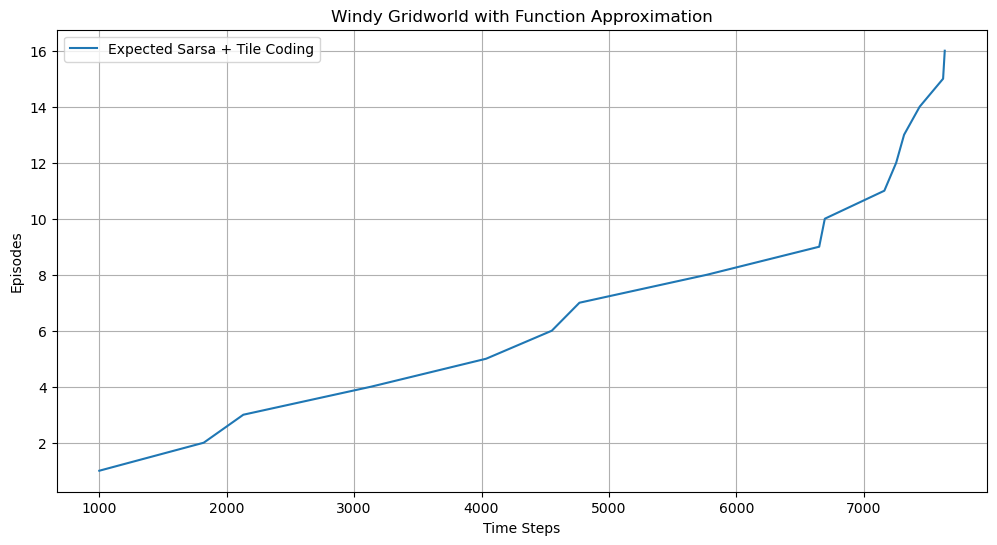

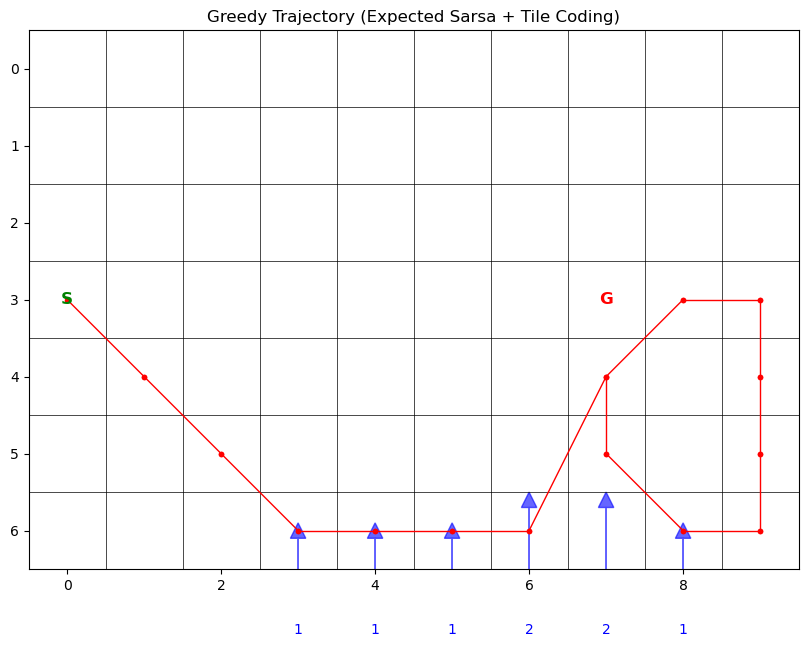

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class TileCoder:
    def __init__(self, n_tilings=8, tiles=(8, 8)):
        self.n_tilings = n_tilings
        self.tiles = tiles
        self.tile_width = (GRID_HEIGHT / tiles[0], GRID_WIDTH / tiles[1])
        self.offsets = [
            (i * self.tile_width[0] / n_tilings, i * self.tile_width[1] / n_tilings)
            for i in range(n_tilings)
        ]

    def get_features(self, state):
        y, x = state
        features = []
        for tiling_idx, (off_y, off_x) in enumerate(self.offsets):
            tile_y = int((y + off_y) / self.tile_width[0])
            tile_x = int((x + off_x) / self.tile_width[1])
            
            tile_y = min(tile_y, self.tiles[0] - 1)
            tile_x = min(tile_x, self.tiles[1] - 1)
            
            index = tiling_idx * self.tiles[0] * self.tiles[1] + tile_y * self.tiles[1] + tile_x
            features.append(index)
        return features

class LinearQ_TileCoding:
    def __init__(self, n_actions, tile_coder):
        self.n_actions = n_actions
        self.tile_coder = tile_coder
        self.n_features = tile_coder.n_tilings * np.prod(tile_coder.tiles)
        self.W = np.zeros((n_actions, self.n_features))

    def q_value(self, state, action_idx):
        indices = self.tile_coder.get_features(state)
        return np.sum(self.W[action_idx, indices])

    def q_values(self, state):
        indices = self.tile_coder.get_features(state)
        return np.sum(self.W[:, indices], axis=1)

    def update(self, state, action_idx, target, alpha):
        indices = self.tile_coder.get_features(state)
        prediction = np.sum(self.W[action_idx, indices])
        td_error = target - prediction
        self.W[action_idx, indices] += (alpha / self.tile_coder.n_tilings) * td_error

def epsilon_greedy(Q, state, epsilon, actions):
    if np.random.rand() < epsilon:
        return np.random.randint(len(actions))
    return np.argmax(Q.q_values(state))

def expected_sarsa_tilecoding(num_episodes, actions):
    """ 
    Expected Sarsa 로 변경합니다. 
    """
    tile_coder = TileCoder(n_tilings=8, tiles=(8, 8))
    Q = LinearQ_TileCoding(len(actions), tile_coder)
    steps_per_episode = []

    for ep in tqdm(range(num_episodes), desc="Expected Sarsa with Tile Coding"):
        state = START_STATE
        step_count = 0

        while True:
            action_idx = epsilon_greedy(Q, state, EPSILON, actions)
            next_state, reward = env_step_stochastic_wind(state, action_idx, actions)
            step_count += 1

            if next_state == GOAL_STATE:
                Q.update(state, action_idx, reward, ALPHA)
                break

            q_next = Q.q_values(next_state)
            greedy_action = np.argmax(q_next)
            
            expected_value = (
                (1 - EPSILON) * q_next[greedy_action]
                + (EPSILON / len(actions)) * np.sum(q_next)
            )

            target = reward + GAMMA * expected_value
            Q.update(state, action_idx, target, ALPHA)
            state = next_state

            if step_count > 1000:
                break

        steps_per_episode.append(step_count)

    return Q, steps_per_episode

NUM_EPISODES = 8000
Q_tile, steps_tile = expected_sarsa_tilecoding(NUM_EPISODES, ACTIONS_8)

def plot_results(results, labels, title):
    plt.figure(figsize=(12, 6))
    for res, label in zip(results, labels):
        cumulative_steps = np.cumsum(res)
        episodes_within_limit = np.sum(cumulative_steps <= 8000)
        plt.plot(cumulative_steps[:episodes_within_limit], np.arange(1, episodes_within_limit + 1), label=label)
    plt.xlabel('Time Steps')
    plt.ylabel('Episodes')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results([steps_tile], ["Expected Sarsa + Tile Coding"], "Windy Gridworld with Function Approximation")

def plot_greedy_trajectory(Q, actions, start, goal, title="Greedy Trajectory"):
    plt.figure(figsize=(10, 7))
    plt.imshow(np.zeros((GRID_HEIGHT, GRID_WIDTH)), cmap='bone_r', origin='upper', extent=[-0.5, GRID_WIDTH-0.5, GRID_HEIGHT-0.5, -0.5])
    for x in range(GRID_WIDTH):
        if WIND[x] > 0:
            plt.arrow(x, GRID_HEIGHT - 0.5, 0, -0.4 * WIND[x], color='blue', head_width=0.2, head_length=0.2, alpha=0.6)
            plt.text(x, GRID_HEIGHT + 0.2, str(WIND[x]), color='blue', ha='center', va='top', fontsize=10)
    plt.text(start[1], start[0], 'S', color='green', ha='center', va='center', fontsize=12, weight='bold')
    plt.text(goal[1], goal[0], 'G', color='red', ha='center', va='center', fontsize=12, weight='bold')
    plt.hlines(np.arange(-0.5, GRID_HEIGHT), -0.5, GRID_WIDTH-0.5, color='black', linewidth=0.5)
    plt.vlines(np.arange(-0.5, GRID_WIDTH), -0.5, GRID_HEIGHT-0.5, color='black', linewidth=0.5)

    state = start
    path = [state]
    visited = set()
    for _ in range(500):
        if state == goal or state in visited:
            break
        visited.add(state)
        q_vals = Q.q_values(state)
        action_idx = np.argmax(q_vals)
        y, x = state
        dy, dx = actions[action_idx]
        ny, nx = y + dy - WIND[x], x + dx
        ny = np.clip(ny, 0, GRID_HEIGHT - 1)
        nx = np.clip(nx, 0, GRID_WIDTH - 1)
        plt.plot([x, nx], [y, ny], 'r-o', markersize=3, linewidth=1)
        state = (ny, nx)
        path.append(state)
    plt.title(title)
    plt.show()

plot_greedy_trajectory(Q_tile, ACTIONS_8, START_STATE, GOAL_STATE, "Greedy Trajectory (Expected Sarsa + Tile Coding)")

## 2.3. True Online Sarsa($\lambda$)

True Online Sarsa(λ) with Tile Coding:   0%|          | 0/8000 [00:00<?, ?it/s]

True Online Sarsa(λ) with Tile Coding: 100%|██████████| 8000/8000 [00:12<00:00, 630.27it/s]


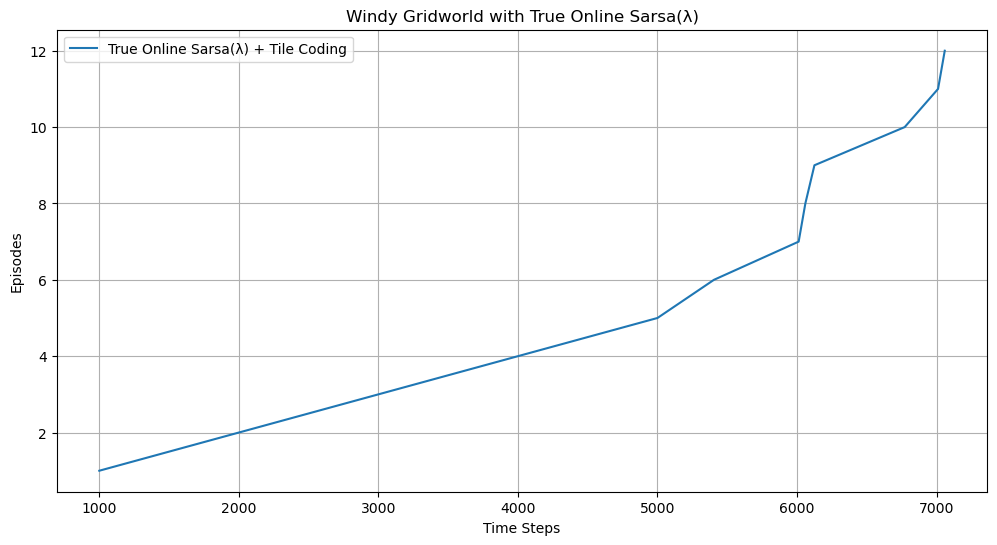

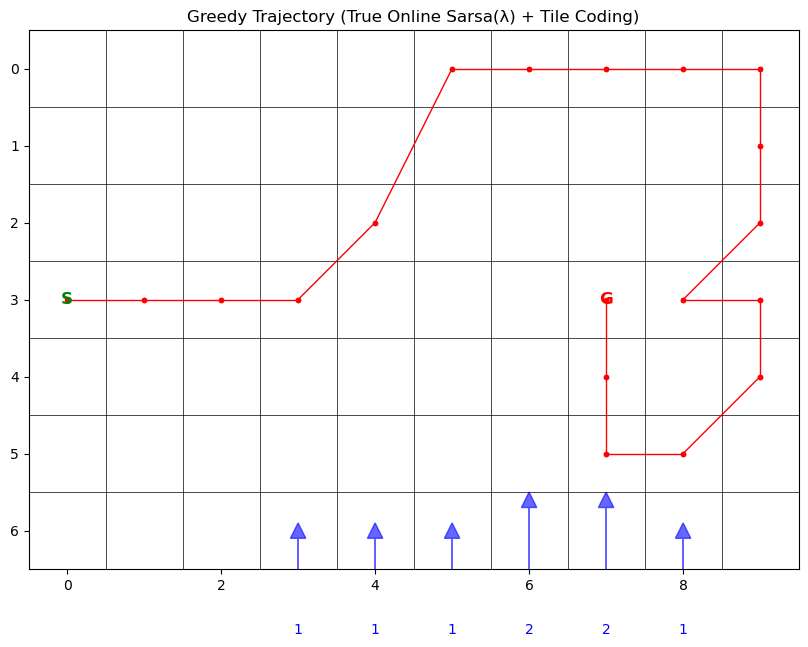

In [9]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def true_online_sarsa_lambda_tilecoding(num_episodes, actions, lam):
    """
    Sutton & Barto (2nd ed.)의 True Online Sarsa(λ) 알고리즘을
    타일 코딩을 이용한 선형 함수 근사 형태로 구현한 코드입니다.
    
    환경 정의, TileCoder, LinearQ_TileCoding, epsilon_greedy,
    env_step_stochastic_wind 등은 이전 셀에서 정의한 것을 그대로 사용합니다.
    """
    n_actions = len(actions)
    
    tile_coder = TileCoder(n_tilings=8, tiles=(8, 8))
    Q_func = LinearQ_TileCoding(n_actions, tile_coder)
    
    alpha = ALPHA / tile_coder.n_tilings
    
    W = Q_func.W  # Q_func.W와 동일한 배열을 참조
    Z = np.zeros_like(W)
    
    steps_per_episode = []
    
    for ep in tqdm(range(num_episodes), desc="True Online Sarsa(λ) with Tile Coding"):
        state = START_STATE
        
        Z[:, :] = 0.0
        Q_old = 0.0
        
        action_idx = epsilon_greedy(Q_func, state, EPSILON, actions)
        indices = tile_coder.get_features(state)
        Q_current = np.sum(W[action_idx, indices])
        
        step_count = 0
        
        while True:
            next_state, reward = env_step_stochastic_wind(state, action_idx, actions)
            step_count += 1
            
            if next_state == GOAL_STATE or step_count >= 1000:
                done = True
                Q_next = 0.0
                next_action_idx = None
                next_indices = None
            else:
                done = False
                next_action_idx = epsilon_greedy(Q_func, next_state, EPSILON, actions)
                next_indices = tile_coder.get_features(next_state)
                Q_next = np.sum(W[next_action_idx, next_indices])
            
            # 교재의 δ = R + γ Q(S',A') - Q(S,A)
            delta = reward + GAMMA * Q_next - Q_current
            
            # z^T x 계산 (현재 상태-행동에 해당하는 특징들에 대해 trace의 합)
            z_dot_x = np.sum(Z[action_idx, indices])
            
            # Dutch trace 갱신: z ← γ λ z + (1 - α γ λ z^T x) x
            Z *= GAMMA * lam
            Z[action_idx, indices] += (1.0 - alpha * GAMMA * lam * z_dot_x)
            
            # 가중치 갱신:
            # w ← w + α (δ + Q(S,A) - Q_old) z - α (Q(S,A) - Q_old) x
            W += alpha * (delta + Q_current - Q_old) * Z
            W[action_idx, indices] -= alpha * (Q_current - Q_old)
            
            # 에피소드 종료 처리
            if done:
                break
            
            # 다음 스텝 준비 (S ← S', A ← A', Q_old ← Q(S',A'), Q(S,A) 갱신)
            state = next_state
            action_idx = next_action_idx
            indices = next_indices
            Q_old = Q_next
            Q_current = Q_next
        
        steps_per_episode.append(step_count)
    
    return Q_func, steps_per_episode


LAMBDA = 0.9
NUM_EPISODES_TRUE = 8000

Q_true, steps_true = true_online_sarsa_lambda_tilecoding(NUM_EPISODES_TRUE, ACTIONS_8, LAMBDA)

plot_results(
    [steps_true],
    ["True Online Sarsa(λ) + Tile Coding"],
    "Windy Gridworld with True Online Sarsa(λ)"
)

plot_greedy_trajectory(
    Q_true,
    ACTIONS_8,
    START_STATE,
    GOAL_STATE,
    "Greedy Trajectory (True Online Sarsa(λ) + Tile Coding)"
)